## Import Library and Initialize Global Variables

In [1]:
pip install wordcloud

     |████████████████████████████████| 366 kB 4.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import joblib
import pickle

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,\
                            precision_score, recall_score, roc_curve,\
                            roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

SEED = 41

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
import sys
print(sys.executable)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python


## Load Database/Import Data

In [5]:
df = pd.read_csv("train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Defining function to save the model to S3 Bucket.

In [6]:
import boto3 
from io import BytesIO 

def write_joblib(file, path):
    # Path is an s3 bucket
    if path[:5] == 's3://':
        s3_bucket, s3_key = path.split('/')[2], path.split('/')[3:]
        s3_key = '/'.join(s3_key)
        with BytesIO() as f:
            joblib.dump(file, f)
            f.seek(0)
            boto3.client("s3").upload_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)
    else:
        with open(path, 'wb') as f:
            joblib.dump(file, f)

## Exploratory Data Analysis (EDA)

In [7]:
df.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [9]:
df.shape
#rows and columns

(20800, 5)

In [10]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [11]:
df=df.dropna()

In [12]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

<AxesSubplot:>

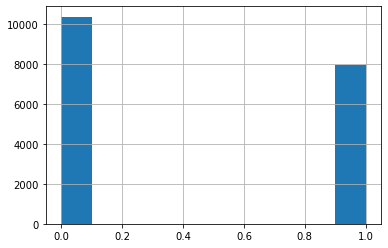

In [13]:
df['label'].hist()

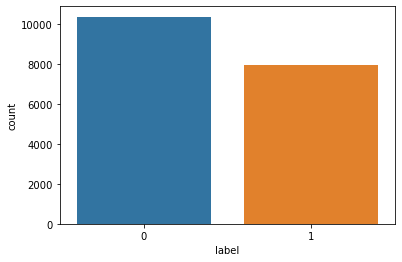

In [14]:
_ = sns.countplot(x="label", data=df)

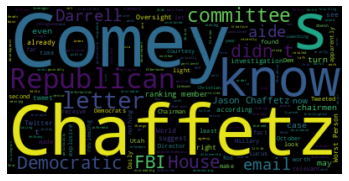

In [15]:
# WordCloud
text = df.text[0]
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
label1_df = df[df['label'] == 1]
print (label1_df)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
12        12  Russian Researchers Discover Secret Nazi Milit...   
...      ...                                                ...   
20788  20788  Maine’s Gov. LePage Threatens To ‘Investigate’...   
20791  20791  Lawyer Who Kept Hillary Campaign Chief Out of ...   
20793  20793  Idiot Who Destroyed Trump Hollywood Star Gets ...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                   author                                               text  \
0           Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...   
2      Consortiumnews.com  Why the 

## Data Preprocessing/Feature Engineering

In [17]:
df.drop(['id','author','title'],axis=1,inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18285 non-null  object
 1   label   18285 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


## Model Selection

### Split Data (Features/Target, Train/Validation/Testing)

In [19]:
X=df['text']
y=df['label']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

#### Feature Scaling (Normalization/Standardization)

In [21]:
#Bag of Words (Bow) method/technique
countVect = CountVectorizer()
countVect.fit(X)

X_train_cv = countVect.transform(X_train)
X_test_cv = countVect.transform(X_test)

len(countVect.get_feature_names())

160355

In [22]:
X_train_cv.shape

(14628, 160355)

## Evaluate Multiple Models and Select Best Model

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X_train_cv,y_train)

y_prednb=nb.predict(X_test_cv);
print(classification_report(y_test, y_prednb))

cm=confusion_matrix(y_test,y_prednb);

acc=accuracy_score(y_test,y_prednb)
print("Accuracy is : %0.3f" % acc)


              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2072
           1       0.94      0.84      0.89      1585

    accuracy                           0.91      3657
   macro avg       0.92      0.90      0.91      3657
weighted avg       0.91      0.91      0.91      3657

Accuracy is : 0.910


In [25]:
%%time
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_cv, y_train)
y_pred = lr.predict(X_test_cv)
acc=accuracy_score(y_test,y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2072
           1       0.95      0.95      0.95      1585

    accuracy                           0.96      3657
   macro avg       0.96      0.96      0.96      3657
weighted avg       0.96      0.96      0.96      3657

CPU times: user 11.1 s, sys: 3.24 s, total: 14.3 s
Wall time: 7.38 s


In [26]:
#Initialize a PassiveAggressiveClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=80)
pac.fit(X_train_cv,y_train)

y_predpac=pac.predict(X_test_cv)

cm=confusion_matrix(y_test,y_predpac);

acc=accuracy_score(y_test,y_predpac)

print(classification_report(y_test, y_predpac))

print("Accuracy is : %0.3f" % acc)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2072
           1       0.92      0.93      0.93      1585

    accuracy                           0.94      3657
   macro avg       0.93      0.94      0.93      3657
weighted avg       0.94      0.94      0.94      3657

Accuracy is : 0.936


### Training models with TF-IDF technique

In [27]:
#TF-IDF method/technique
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit(X)

X_train_cv = tfidf.transform(X_train)
X_test_cv = tfidf.transform(X_test)

len(tfidf.get_feature_names())

160045

In [28]:
%%time
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_cv, y_train)
y_pred = lr.predict(X_test_cv)

print(classification_report(y_test, y_pred))
acc=accuracy_score(y_test,y_pred)
print("Accuracy is : %0.3f" % acc)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2072
           1       0.95      0.94      0.94      1585

    accuracy                           0.95      3657
   macro avg       0.95      0.95      0.95      3657
weighted avg       0.95      0.95      0.95      3657

Accuracy is : 0.952
CPU times: user 3.65 s, sys: 921 ms, total: 4.57 s
Wall time: 2.45 s


In [29]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X_train_cv,y_train)

y_prednb=nb.predict(X_test_cv);
print(classification_report(y_test, y_prednb))

cm=confusion_matrix(y_test,y_prednb);

acc=accuracy_score(y_test,y_prednb)
print("Accuracy is : %0.3f" % acc)

              precision    recall  f1-score   support

           0       0.70      1.00      0.82      2072
           1       1.00      0.44      0.61      1585

    accuracy                           0.76      3657
   macro avg       0.85      0.72      0.72      3657
weighted avg       0.83      0.76      0.73      3657

Accuracy is : 0.757


In [30]:
#Initialize a PassiveAggressiveClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=80)
pac.fit(X_train_cv,y_train)

y_predpac=pac.predict(X_test_cv)

cm=confusion_matrix(y_test,y_predpac);
print(classification_report(y_test, y_predpac))
acc=accuracy_score(y_test,y_predpac)
print("Accuracy is : %0.3f" % acc)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2072
           1       0.95      0.96      0.95      1585

    accuracy                           0.96      3657
   macro avg       0.96      0.96      0.96      3657
weighted avg       0.96      0.96      0.96      3657

Accuracy is : 0.961


In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_predpac)
print('roc_auc_score for PAC: ', roc_auc_score(y_test, y_predpac))

roc_auc_score for PAC:  0.9603021509567251


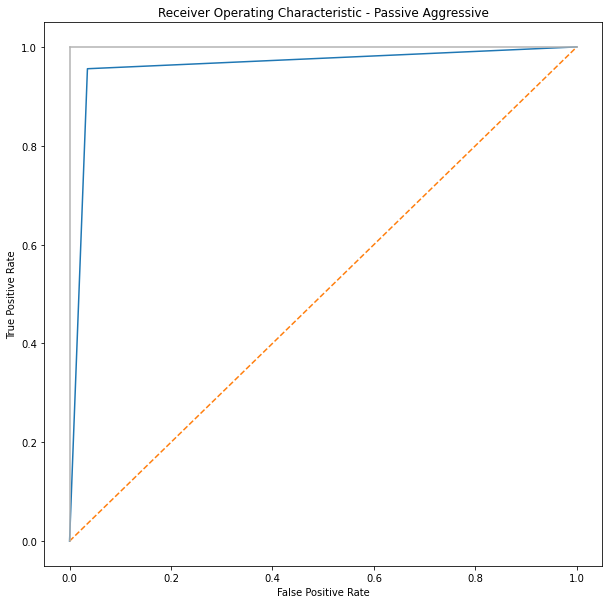

In [44]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Passive Aggressive')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(33.0, 0.5, 'Predicted')

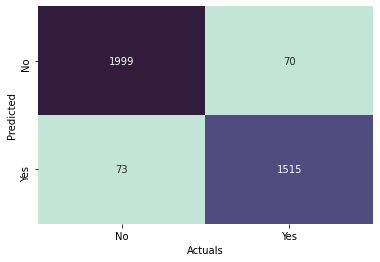

In [33]:
## Confusion Matrix

conf_mat = confusion_matrix(y_test, y_predpac)
sns.heatmap(conf_mat.T, annot=True, fmt='d', cbar=False, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('Actuals')
plt.ylabel('Predicted')

In [34]:
#cross-validation score
cross_val_score(pac, X_test_cv, y_test, cv=10, scoring = 'accuracy').mean()

0.9390216333557901

## Saving the models in the Bucket

In [35]:
write_joblib(lr, 's3://myfakenews/lr.pkl')
write_joblib(nb, 's3://myfakenews/nb.pkl')

In [36]:
write_joblib(pac, 's3://myfakenews/pac.pkl')

## Loading the models back from the Bucket

In [ ]:
def read_joblib(path):
    ''' 
       Function to load a joblib file from an s3 bucket or local directory.
       Arguments:
       * path: an s3 bucket or local directory path where the file is stored
       Outputs:
       * file: Joblib file loaded
    '''

    # Path is an s3 bucket
    if path[:5] == 's3://':
        s3_bucket, s3_key = path.split('/')[2], path.split('/')[3:]
        s3_key = '/'.join(s3_key)
        with BytesIO() as f:
            boto3.client("s3").download_fileobj(Bucket=s3_bucket, Key=s3_key, Fileobj=f)
            f.seek(0)
            file = joblib.load(f)
    
    # Path is a local directory 
    else:
        with open(path, 'rb') as f:
            file = joblib.load(f)
    
    return file

In [ ]:
mdl_lightgbm = read_joblib('s3://bucket_name/mdl_dict.joblib')
mdl_lightgbm = mdl_lightgbm['mdl_fitted']